# Generating OCR Synthetic Data

We'd like to some synthetic OCR data. Plan is to:

1. Load a relevant text based dataset.
2. Generate the OCR data.
3. Test this on an OCR model.

In [2]:
# load the dataset
from datasets import load_dataset

dataset = load_dataset(
    "multi_eurlex",
    "all_languages",
    label_level="level_3",
    trust_remote_code=True,
)

dataset

DatasetDict({
    train: Dataset({
        features: ['celex_id', 'text', 'labels'],
        num_rows: 55000
    })
    test: Dataset({
        features: ['celex_id', 'text', 'labels'],
        num_rows: 5000
    })
    validation: Dataset({
        features: ['celex_id', 'text', 'labels'],
        num_rows: 5000
    })
})

Now to investigate how to synthesise the OCR data using the `trdg` module.

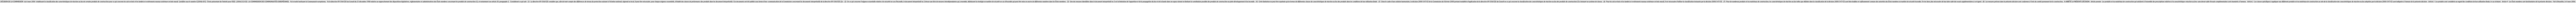

In [12]:
from trdg.generators import GeneratorFromStrings

examples = [dataset['train'][i]['text']['fr'] for i in range(3)]
generator = GeneratorFromStrings(examples)
next(generator)[0]

Ok, so this creates some text, but it's too long to really be useable by eye, lets do something smaller

test


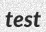

In [14]:
gen = GeneratorFromStrings(['test'])
out = next(gen)
print(out[1])
out[0]

Ok, that's more like it.

Let's grab an OCR model and try some inference to test this

In [23]:
# load the model
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# model.to(device)

/Users/edable-heath/Documents/ARC-SPICE/.venv-3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


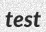

In [24]:
image = out[0]
image

In [25]:
pixel_values = processor(image, return_tensors='pt').pixel_values
pixel_values.to(device)
pixel_values

tensor([[[[0.7020, 0.7020, 0.7020,  ..., 0.8745, 0.8745, 0.8745],
          [0.7020, 0.7020, 0.7020,  ..., 0.8745, 0.8745, 0.8745],
          [0.7020, 0.7020, 0.7020,  ..., 0.8745, 0.8745, 0.8745],
          ...,
          [0.7882, 0.7882, 0.7882,  ..., 0.7020, 0.7020, 0.7020],
          [0.7882, 0.7882, 0.7882,  ..., 0.7020, 0.7020, 0.7020],
          [0.7882, 0.7882, 0.7882,  ..., 0.7020, 0.7020, 0.7020]],

         [[0.7020, 0.7020, 0.7020,  ..., 0.8745, 0.8745, 0.8745],
          [0.7020, 0.7020, 0.7020,  ..., 0.8745, 0.8745, 0.8745],
          [0.7020, 0.7020, 0.7020,  ..., 0.8745, 0.8745, 0.8745],
          ...,
          [0.7882, 0.7882, 0.7882,  ..., 0.7020, 0.7020, 0.7020],
          [0.7882, 0.7882, 0.7882,  ..., 0.7020, 0.7020, 0.7020],
          [0.7882, 0.7882, 0.7882,  ..., 0.7020, 0.7020, 0.7020]],

         [[0.7020, 0.7020, 0.7020,  ..., 0.8745, 0.8745, 0.8745],
          [0.7020, 0.7020, 0.7020,  ..., 0.8745, 0.8745, 0.8745],
          [0.7020, 0.7020, 0.7020,  ..., 0

In [26]:
generated_ids = model.generate(pixel_values)

/Users/edable-heath/Documents/ARC-SPICE/.venv-3.10/lib/python3.10/site-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [27]:
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [28]:
generated_text

'test'

Ok, so this seems to work, lets write a generation script to create a dataset, first looking into further data manipulation in the image generation.

In [88]:
ocr_gen = GeneratorFromStrings(examples, language='fr', random_blur=True, random_skew=True, skewing_angle=45, blur=1)

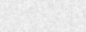

In [87]:
next(ocr_gen)[0]